In [1]:
import GPy
from GPy.kern.src.stationary import Stationary
from GPy.core import Param
from paramz.transformations import Logexp
import numpy as np

## Corrected Implementation of Rational Quadratic Kernel
GPy's `RatQuad` kernel is missing an $\alpha$ factor in the denominator. The corrected rational quadratic kernel is defined as:

$k_{RQ}(x,x') = \sigma^{2}\left(1 + \frac{(x - x')^2}{2 \alpha \ell^2} \right)^{-\alpha}$

See https://github.com/SheffieldML/GPy/issues/727

In [2]:
class RationalQuadratic(Stationary):
    def __init__(self, input_dim, variance=1., lengthscale=None, power=2., ARD=False, active_dims=None, name='rat_quad'):
        super(RationalQuadratic, self).__init__(input_dim, variance, lengthscale, ARD, active_dims, name)
        self.power = Param('power', power, Logexp())
        self.link_parameters(self.power)

    def to_dict(self):
        """
        Convert the object into a json serializable dictionary.

        Note: It uses the private method _save_to_input_dict of the parent.

        :return dict: json serializable dictionary containing the needed information to instantiate the object
        """

        input_dict = super(RationalQuadratic, self)._save_to_input_dict()
        input_dict["class"] = "GPy.kern.RationalQuadratic"
        input_dict["power"] = self.power.values.tolist()
        return input_dict

    @staticmethod
    def _build_from_input_dict(kernel_class, input_dict):
        useGPU = input_dict.pop('useGPU', None)
        return RationalQuadratic(**input_dict)

    def K_of_r(self, r):
        r2 = np.square(r)
        return self.variance * np.exp(-self.power * np.log1p(r2 / (2.*self.power)))

    def dK_dr(self, r):
        r2 = np.square(r)
        return -self.variance * r * np.exp(-(self.power + 1) * np.log1p(r2 / (2.*self.power)))

    def update_gradients_full(self, dL_dK, X, X2=None):
        super(RationalQuadratic, self).update_gradients_full(dL_dK, X, X2)
        r = self._scaled_dist(X, X2)
        r2 = np.square(r) + np.spacing(1) # add epsilon for numerical stability
        dK_dpow = self.K_of_r(r) * (np.exp(np.log(r2) - np.log(r2 + 2.*self.power)) - np.log1p(r2 / (2.*self.power)))
        grad = np.sum(dL_dK*dK_dpow)
        self.power.gradient = grad

    def update_gradients_diag(self, dL_dKdiag, X):
        super(RationalQuadratic, self).update_gradients_diag(dL_dKdiag, X)
        self.power.gradient = 0.

### Test Implementation
Use GPML's `@covRQiso` to test correctness

 C:\Users\lousc\Anaconda3\envs\py3-6\lib\site-packages\matplotlib\figure.py:2369: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


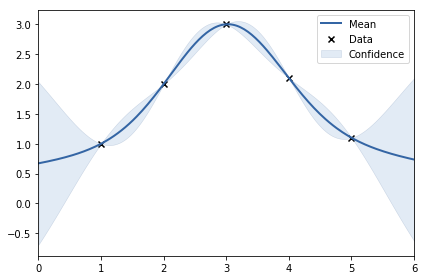

In [3]:
X = np.array([1, 2, 3, 4, 5]).reshape(-1, 1)
y = np.array([1, 2, 3, 2.1, 1.1]).reshape(-1, 1) 

ell = 1.5
alpha = 2.1
sf  = 2.5**2
sn  = 0.1**2

k = RationalQuadratic(1, variance=sf, lengthscale=ell, power=alpha)

gpml_result = np.array([
    [6.25      , 5.05990782, 2.97831081, 1.53353763, 0.78044529],
    [5.05990782, 6.25      , 5.05990782, 2.97831081, 1.53353763],
    [2.97831081, 5.05990782, 6.25      , 5.05990782, 2.97831081],
    [1.53353763, 2.97831081, 5.05990782, 6.25      , 5.05990782],
    [0.78044529, 1.53353763, 2.97831081, 5.05990782, 6.25      ]])

# Test covariance matrix correctness
cov_mat = k.K(X, X)
assert np.allclose(cov_mat, gpml_result)

m = GPy.models.GPRegression(X, y, kernel=k, noise_var=sn)
m.optimize_restarts(verbose=False)
m.plot()

# Test negative log marginal likelihood correctness
gpml_nlml = 6.3644
assert np.isclose(gpml_nlml, -m.log_likelihood(), rtol=1e-03)

### Compare to GPy RatQuad kernel

In [4]:
ratquad = GPy.kern.RatQuad(1, variance=sf, lengthscale=ell, power=alpha)
ratquad.K(X)

array([[6.25      , 4.10076279, 1.64379083, 0.62219337, 0.25878744],
       [4.10076279, 6.25      , 4.10076279, 1.64379083, 0.62219337],
       [1.64379083, 4.10076279, 6.25      , 4.10076279, 1.64379083],
       [0.62219337, 1.64379083, 4.10076279, 6.25      , 4.10076279],
       [0.25878744, 0.62219337, 1.64379083, 4.10076279, 6.25      ]])

'nlml =6.364352628474249'

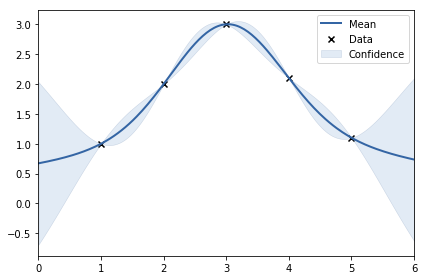

In [5]:
m = GPy.models.GPRegression(X, y, kernel=ratquad, noise_var=sn)
m.optimize_restarts(verbose=False)
m.plot()
'nlml =' + str(-m.log_likelihood())